In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pymc as pm
import arviz as az
!pip install pingouin
import pingouin as pg
from statsmodels.stats.power import FTestAnovaPower

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.3 MB/s eta 0:00:00


# Devamlı Veriler Üzerinde Uygulanan İstatistiki Prosedürler



## Bartlett Testi

T-test, karşılaştırılacak iki verinin unimodal olduğunu ve aşağı yukları eşit varyansa sahip olduğunu varsayar. Eğer varyans varsayımı karşılanmaz ise Welch t-test kullanılır. Varyans kıyaslaması için bartlett testi kullanılabilir.

In [ ]:
group1 = np.random.normal(loc = 10, scale = 5, size = 100)
group2 = np.random.normal(loc = 11, scale = 1, size = 100)

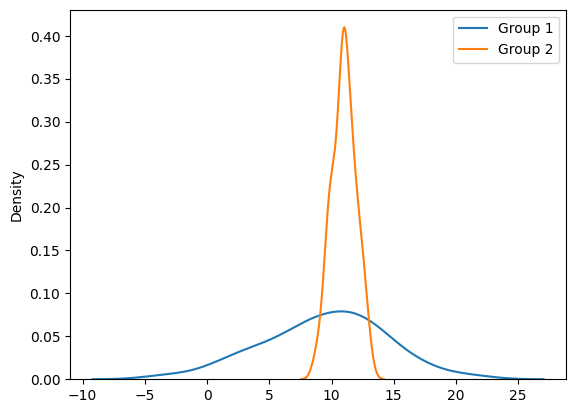

In [ ]:
sns.kdeplot(group1, label = "Group 1")
sns.kdeplot(group2, label = "Group 2")
plt.legend()
plt.show()

In [ ]:
stats.bartlett(group1, group2)

BartlettResult(statistic=193.1582587389934, pvalue=6.501004475060759e-44)

İki grup eşit varyansa sahip değil.

In [ ]:
test_results = stats.ttest_ind(group1, group2, equal_var = False)
test_results

TtestResult(statistic=-3.083579936278918, pvalue=0.002605050090630927, df=106.49312326486175)

## Nonparametrik Bootstrap Testi

Alternatif olarak `Bootstrap nonparametrik testini` kullanabilirsin.

In [ ]:
group1_simulations = stats.bootstrap((group1,), statistic = np.mean, n_resamples = 10000)
group2_simulations = stats.bootstrap((group2,), statistic = np.mean, n_resamples = 10000)
difference = group1_simulations.bootstrap_distribution - group2_simulations.bootstrap_distribution

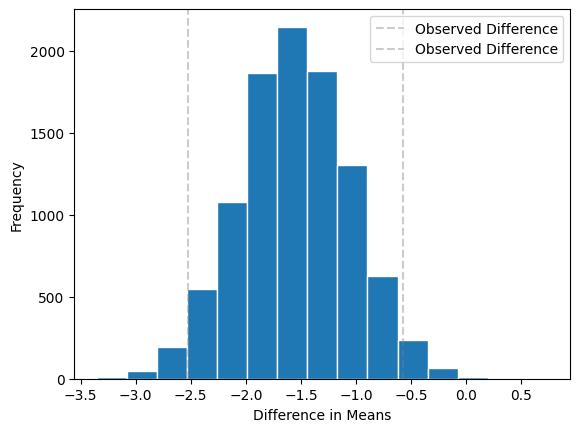

In [ ]:
observed_difference = np.mean(group1) - np.mean(group2)

plt.figure()
plt.hist(difference, bins = 15, edgecolor = "white")
plt.axvline(np.percentile(difference,2.5), linestyle = "--",color = "grey",alpha = 0.4, label = "Observed Difference")
plt.axvline(np.percentile(difference,97.5),linestyle = "--", color = "grey",alpha = 0.4, label = "Observed Difference")
plt.xlabel("Difference in Means")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Persentil aralığı 0'ı içermiyor yani 95% eminiz ki iki grup birbirinden farklı ve bu fark -2.5 ile ~-0.5 aralığında.

## Nonparametrik Permütasyon Testi

In [ ]:
combined_group = np.concatenate((group1, group2))
observed_difference = np.mean(group1) - np.mean(group2)
p_values = 0
resulting_distribution = []

for i in range(10000):
    np.random.shuffle(combined_group)
    simulated1,simulated2 = combined_group[:100], combined_group[100:]
    simulated_difference = np.mean(simulated1) - np.mean(simulated2)
    if np.abs(simulated_difference) >= np.abs(observed_difference): #iki kuyruklu
        p_values += 1

    resulting_distribution.append(simulated_difference)

resulting_distribution = np.array(resulting_distribution)
p_values = p_values/10000
p_values

0.0018

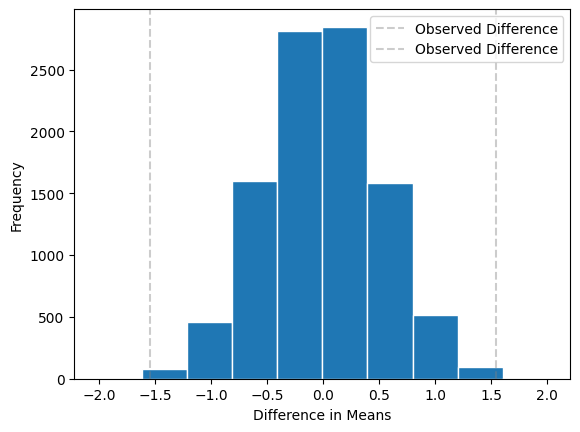

In [ ]:
plt.figure()
plt.hist(resulting_distribution,edgecolor = "white")
plt.axvline(observed_difference,linestyle = "--",color = "grey",alpha = 0.4, label = "Observed Difference")
plt.axvline(-observed_difference,linestyle = "--",color = "grey",alpha = 0.4, label = "Observed Difference")
plt.xlabel("Difference in Means")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Aradaki farkın tesadüfi olma ihtimali 5%'den az. O halde gerçekten iki grup birbirinden farklı.

## Corrective Analiz

Alpha, Tip 1 hata oranı ihtimalidir. Örneğin $α = 0.05$ ise 5% ihtimalle null hipotezi doğru olmasına rağmen reddedilir (False Positive). Dolayısıyla bir veri seti için birden fazla test yaptığımızda bu ihtimaller birikir ve Tip 1 hata yapma olasılığımız artar. Testler **bapımsız** olsa dahi bir veri setinde farklı testler uyguladıkça Tip 1 hatayı kontrol altında tutmamız gerekir. Bonferroni düzeltmesine göre $p_{new} = \frac p m$ şeklinde ayarlanır. Buradaki m her türlü permütasyon testi, bootstrap CI testi gibi nonparametrik yolları da kapsar.

In [ ]:
x1 = np.random.normal(loc = 10, scale = 2,size = 100)
x2 = np.random.normal(loc = 11, scale = 2,size = 100)
x3 = np.random.normal(loc = 12, scale = 2,size = 100)

test_perform = 3
alpha = 0.05
p_new = alpha/test_perform

from itertools import combinations

for i in combinations([x1,x2,x3],2):
    print(stats.ttest_ind(i[0],i[1]))
    if stats.ttest_ind(i[0],i[1])[1] < p_new:
        print("Reject Null")
    else:
        print("Fail to Reject Null")



TtestResult(statistic=-3.7664657349529076, pvalue=0.0002182863237099728, df=198.0)
Reject Null
TtestResult(statistic=-7.41588594650811, pvalue=3.456727490108157e-12, df=198.0)
Reject Null
TtestResult(statistic=-3.3771817587300945, pvalue=0.000881567009944619, df=198.0)
Reject Null


## ANOVA

**Varsayımlar**
* Gauss dağılımı (unimodal, aşırı uç veriler yok)
* Benzer varyanslar
* Bağımsız örnekler
* Devamlı Veri (nominal veya ordinal veriler üzerinde kullanılmaz)

In [ ]:
x1 = np.random.normal(loc = 10, scale = 2,size = 1000)
x2 = np.random.normal(loc = 11, scale = 2,size = 1000)
x3 = np.random.normal(loc = 11, scale = 2,size = 1000)
print(stats.bartlett(x1,x2,x3))

stats.f_oneway(x1,x2,x3)

BartlettResult(statistic=2.537295882159238, pvalue=0.2812115794824496)


F_onewayResult(statistic=70.07566296556277, pvalue=1.8058650014933328e-30)

## Post-Hoc Analizleri (Tukey HSD)

### Tukey HSD

**Varsayımlar**
* Gauss dağılımı (unimodal, aşırı uç veriler yok)
* Benzer varyanslar
* Bağımsız örnekler

In [ ]:
post_hoc = stats.tukey_hsd(x1,x2,x3)
print(post_hoc)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.905     0.000    -1.116    -0.695
 (0 - 2)     -0.935     0.000    -1.145    -0.724
 (1 - 0)      0.905     0.000     0.695     1.116
 (1 - 2)     -0.030     0.942    -0.240     0.181
 (2 - 0)      0.935     0.000     0.724     1.145
 (2 - 1)      0.030     0.942    -0.181     0.240



## Etki Boyutu

Test sonucunun pratikte ne denli önemli olduğunu gösterir.

ANOVA için $η^2$ kullanılır.

* 0.01 ≤ η² < 0.06: Küçük etki büyüklüğü
* 0.06 ≤ η² < 0.14: Orta düzeyde etki büyüklüğü
* η² ≥ 0.14: Büyük etki büyüklüğü

### ANOVA

In [ ]:
x1 = np.random.normal(loc = 10, scale = 2,size = 1000)
x2 = np.random.normal(loc = 11, scale = 2,size = 1000)
x3 = np.random.normal(loc = 11, scale = 2,size = 1000)

def eta_squared(*groups):
    # ANOVA testi
    f_stat, p_value = stats.f_oneway(*groups)

    # Toplam ortalamayı hesaplama
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)

    # Toplam Kareler Toplamı (SS Total)
    ss_total = np.sum((all_data - grand_mean) ** 2)

    # Gruplar Arası Kareler Toplamı (SS Between)
    ss_between = sum(len(group) * (np.mean(group) - grand_mean) ** 2 for group in groups)

    # Eta Squared hesaplama
    eta_squared_value = ss_between / ss_total

    # Sonuçları döndürme
    return {
        "F Statistic": f_stat,
        "p-value": p_value,
        "Eta Squared": eta_squared_value
    }

# Örnek kullanım
result = eta_squared(x1, x2, x3)
print(result)

{'F Statistic': 68.52712693401102, 'p-value': 7.933751846565378e-30, 'Eta Squared': 0.043730657725172206}


### T-testi

In [ ]:
pg.ttest(x1,x2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.824493,1998,two-sided,2.797434e-22,"[-1.07, -0.72]",0.439365,1.097e+19,1.0


## Testin Gücü

In [ ]:
effect_size = 0.25 #orta; 0.4 büyük, 0.1 küçük
alpha = 0.05
groups = 3
nobs = 1000

anova_power.solve_power(effect_size = effect_size,
                        nobs = nobs,
                        alpha = alpha,
                        k_groups = groups)

0.9999999860872042

## ANOVA Enhanced Fonksiyonu

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower
import scipy.stats as stats


def eta_squared_to_f(eta_squared):
    return np.sqrt(eta_squared / (1 - eta_squared))


def ANOVA_enhanced(*groups, alpha=0.05):

    test_statistic, p_value = stats.f_oneway(*groups)


    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)


    ss_total = np.sum((all_data - grand_mean) ** 2)


    ss_between = sum(len(group) * (np.mean(group) - grand_mean) ** 2 for group in groups)


    eta_squared_value = ss_between / ss_total


    f_value = eta_squared_to_f(eta_squared_value)


    group_count = len(groups)
    n_obs = sum(len(group) for group in groups)  # Tüm gözlem sayısı
    anova_power = FTestAnovaPower().solve_power(effect_size=f_value,
                                                nobs=n_obs,
                                                alpha=alpha,
                                                k_groups=group_count)


    result = pd.DataFrame(data={
        "Test Statistic": [test_statistic],
        "P-value": [p_value],
        "Eta Squared": [eta_squared_value],
        "Power": [anova_power]
    })
    return result

In [ ]:
x1 = np.random.normal(loc = 10, scale = 2,size = 1000)
x2 = np.random.normal(loc = 11, scale = 2,size = 1000)
x3 = np.random.normal(loc = 11, scale = 2,size = 1000)

ANOVA_enhanced(x1,x2,x3)

,Test Statistic,P-value,Eta Squared,Power
0,104.089517,1.974344e-44,0.064951,1.0


# Örnekleme Metotları

## Cluster Sampling

Veri setindeki her grubu ayırıp oluşan gruplar üzerinden örnekleme yaparak sonuca varmaktır.

In [ ]:
a = np.array(["A"]*5)
a_vals = np.random.randint(0,10,5)
b = np.array(["B"]*5)
b_vals = np.random.randint(0,10,5)

ds = pd.DataFrame({"Groups": np.concatenate((a,b)),"Values": np.concatenate((a_vals,b_vals))})
ds

,Groups,Values
0,A,1
1,A,5
2,A,4
3,A,5
4,A,1
5,B,0
6,B,4
7,B,8
8,B,5
9,B,3


In [ ]:
a_samples = ds.groupby("Groups").apply(lambda x: x.sample(2))
a_samples

<ipython-input-3-46c8cc4850ff>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a_samples = ds.groupby("Groups").apply(lambda x: x.sample(2))


Groups  Values
Groups                 
A      2      A       4
       1      A       5
B      7      B       8
       6      B       4

## Stratified Sampling

Özellikle stratalar popülasyonu daha iyi bir şekilde temsil edebildiğinde kullanılır. Mesela dengesiz veri setleri.

In [ ]:
from sklearn.model_selection import train_test_split
X1,X2,y1,y2 = train_test_split(ds["Values"],ds["Groups"],test_size = 0.5,stratify = ds["Groups"])

# Dağılımlar

## Binom Dağılımı

**Gereksinimler:**

* Denemeler bağımsızdır.
* Deneme sayısı (n) sabittir.
* Sonuçlar 1 ya da 0'dır.
* Her denemede başarı ihtimalı $p$ sabittir.

$\mu = p$

$\sigma = \sqrt{p(1-p)}$

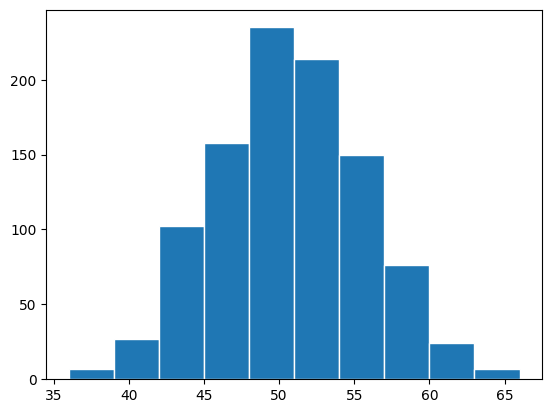

In [ ]:
plt.hist(stats.binom.rvs(n = 100,p = 0.5,size = 1000),edgecolor = "white",bins = 10);

### Normal Approximation of Binomial Distribution

Eğer n yeterince fazlaysa (başarı ve başarısızlık için en az 10 veri) binom dağılıma normal dağılım muamelesi yapılabilir.

$\mu = np$

$\sigma = \sqrt{np(1-p)}$

Bir binom dağılımında olasılık hesabı yapmak için kombinasyon kullanmak gerekir.

$P = \binom{n}{k}(p)^n(1-p)^{n-k}$

Hesaplama zordur. Normal dağılım yuvarlaması ile bu olasılıkları hesaplamak çok kolay olur.

In [ ]:
stats.binom.pmf(n = 20,k = 4,p = 0.5)

0.004620552062988283

In [ ]:
stats.binomtest(n = 20,k = 4, p = 0.5)

BinomTestResult(k=4, n=20, alternative='two-sided', statistic=0.2, pvalue=0.01181793212890625)

## Poisson Dağılımı

k olayın $λ$ hızında oluşu modellenir.

In [ ]:
# 5 olayın 3 lambda'da gerçekleşme olasılığı
proba = stats.poisson.pmf(k = 5,mu = 3)

0.10081881344492458

# İstatistiksel Çıkarımın Temelleri

0.88 başarı ihtimalli 1000 denemenin 10000 defa tekrarlanması sonucu elde edilen başarı sayısının dağılımı aşağıdaki gibidir. $np\geq10$, $n(1-p)\geq10$ ve $n\geq30$ olduğu için merkezi limit teoremi geçerlidir.

In [ ]:
samples = stats.binom.rvs(n = 1000, p = 0.88,size = 10000)

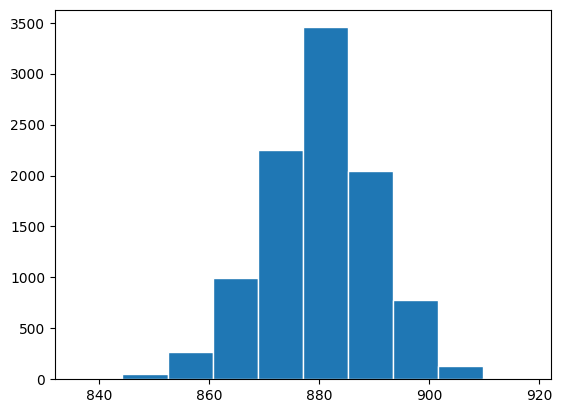

In [ ]:
plt.hist(samples,edgecolor = "white",bins = 10);

Normal approximation'a göre CI bulabiliriz. Bu prosedür sadece gereksinimler sağlandığında yapılabilir!!

In [ ]:
probability_of_samples = samples / 1000 #success to success rate
p_hat = probability_of_samples.mean()
st_error = np.std(probability_of_samples,ddof = 1)

print(f"95% CI Range:({p_hat - 1.96*st_error},{p_hat + 1.96*st_error})")

95% CI Range:(0.8598248612461354,0.8999827387538646)


In [ ]:
stats.binom.pmf(n = n,k = k,p = 0.5)

1.959178513388269e-06

## SORULAR

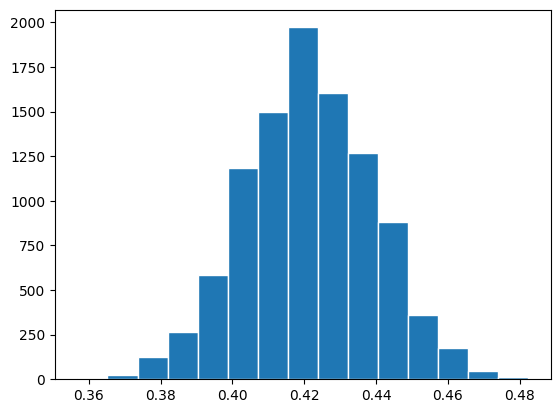

In [ ]:
n = 765
k = 322
p_hat = k/n

probability_distribution = stats.binom.rvs(n = n,p = p_hat,size = 10000) / n
plt.hist(probability_distribution, edgecolor = "white",bins = 15);

Point estimate nedir?

In [ ]:
point_estimate = probability_distribution.mean()
point_estimate

0.4210711111111112

50% inancı yerinde midir?

Cevap: Hayır

In [ ]:
stats.binomtest(n = n, k = k, p = 0.5)

BinomTestResult(k=322, n=765, alternative='two-sided', statistic=0.42091503267973857, pvalue=1.3794391002287148e-05)

### 2.SORU

k = 27

n = 212

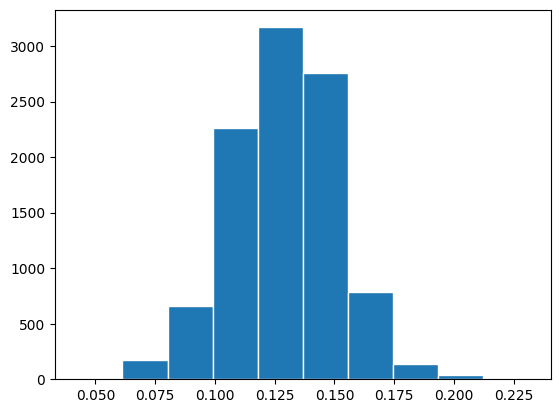

In [ ]:
n = 212
k = 27
p_hat = k/n
probability_distribution = stats.binom.rvs(n = n,p = p_hat,size = 10000) / n
plt.hist(probability_distribution, edgecolor = "white",bins = 10);

10% inancı vardı. Gözlemler inançlara uygun mu?

Evet uyumlu.

In [ ]:
stats.binomtest(n = n, k = k, p = 0.1)

BinomTestResult(k=27, n=212, alternative='two-sided', statistic=0.12735849056603774, pvalue=0.2062499946876116)

Of all freshman at a large college, 16% made the dean's list in the current
year. As part of a class project, students randomly sample 40 students and check if those students made
the list. They repeat this 1,000 times and build a distribution of sample proportions.

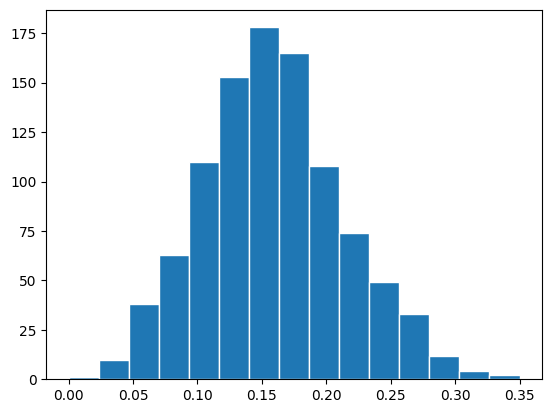

In [ ]:
probability_distribution = stats.binom.rvs(size = 1000, n = 40, p = 0.16) / 40
plt.hist(probability_distribution, edgecolor = "white",bins = 15);

Calculate the variability of this distribution.

In [ ]:
standard_error = np.std(probability_distribution,ddof = 1)
standard_error

0.059115836982843964

Suppose the students decide to sample again, this time collecting 90 students per sample, and they again
collect 1,000 samples. They build a new distribution of sample proportions. How will the variability
of this new distribution compare to the variability of the distribution when each sample contained 40
observations?

Will be lower.

### 3.SORU

In New York City on October 23rd, 2014, a doctor who had recently been treating Ebola
patients in Guinea went to the hospital with a slight fever and was subsequently diagnosed with
Ebola. Soon thereafter, an NBC 4 New York/The Wall Street Journal/Marist Poll found that 82%
of New Yorkers favored a \mandatory 21-day quarantine for anyone who has come in contact with an
Ebola patient". This poll included responses of 1,042 New York adults between Oct 26th and 28th,
2014.

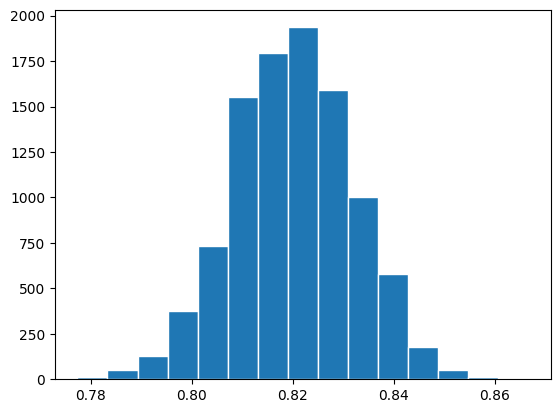

In [ ]:
probability_distribution = stats.binom.rvs(n = 1042, size = 10000, p = 0.82) / 1042
plt.hist(probability_distribution, edgecolor = "white",bins = 15);

In [ ]:
point_estimate = probability_distribution.mean()
point_estimate

0.8201945297504799

In [ ]:
standard_error = probability_distribution.std()
standard_error

0.01184345168799673

In [ ]:
conf_interval = (point_estimate - 1.96*standard_error, point_estimate + 1.96*standard_error)
conf_interval

(0.7969813644420063, 0.8434076950589535)

## Hypotesis Testing for Proportions

n = 228

k = 34

$H_0: p =0.33$
$H_A: p \neq 0.33$

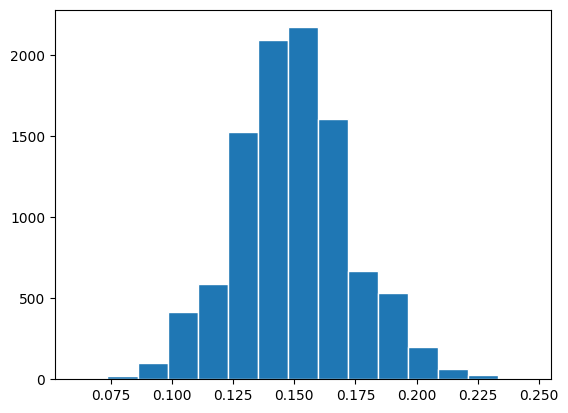

In [ ]:
p_hat = 34/228
probability_distribution = stats.binom.rvs(n = 228, p = p_hat, size = 10000) / 228
plt.hist(probability_distribution, edgecolor = "white",bins = 15);

In [ ]:
point_estimate = probability_distribution.mean()
standard_error = probability_distribution.std()
ci = (point_estimate - 1.96*standard_error, point_estimate + 1.96*standard_error)
ci

(0.10268680436444871, 0.19523073949520037)

CI'nin içerisinde 0.33 olmadığından $H_0$ reddedilir.

Alternatif olarak

In [ ]:
stats.binomtest(n = 228,k = 34, p = 0.33)

BinomTestResult(k=34, n=228, alternative='two-sided', statistic=0.14912280701754385, pvalue=7.93849986931616e-10)

Alternatif olarak kuyrukta olan örnek oranına bakarak çıkarım yapabiliriz.

In [ ]:
(len(np.where(probability_distribution < point_estimate - 1.96*standard_error)[0]) + \
len(np.where(probability_distribution > point_estimate + 1.96*standard_error)[0])) / 10000

0.0494

# İki Proporsiyon Üzerinden Çıkarımlar

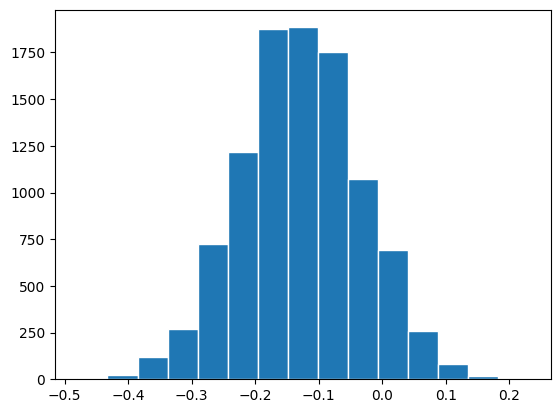

In [ ]:
k1 = 11
n1 = 50

k2 = 14
n2 = 40

p1 = stats.binom.rvs(n = n1, p = k1/n1, size = 10000) / n1
p2 = stats.binom.rvs(n = n2, p = k2/n2, size = 10000) / n2

diff = p1 - p2
plt.hist(diff, edgecolor = "white",bins = 15);

In [ ]:
point_estimate = diff.mean()
standard_error = diff.std()
ci = (point_estimate - 1.645*standard_error, point_estimate + 1.645*standard_error)
ci

(-0.2849452455925333, 0.027635245592533303)

İki grup farklı değildir.

# Kategorik Değişkenler Üzerinden Çıkarımlar

## Tek taraflı Ki-Kare Testi

Birden fazla grubun **kategorik** çıktısının birbirlerinden farklı olup olmadığını test etmek için kullanılır.

$H_0: $Gruplar arasında fark yoktur.

$H_A: $Gruplar arasında fark vardır.



In [ ]:
observed_data = np.array([205,26,25,19])
expected_data = np.array([198,19.25,33,24.75])


stats.chisquare(observed_data,expected_data)

Power_divergenceResult(statistic=5.8896103896103895, pvalue=0.11710619130850619)

Gruplar arasonda fark yoktur.

Gerekirse p-değeri düzenlenerek ikişerli kombinasyonlar arasında post-hoc analizi yapılabilir.

## Çift Taraflı Ki-Kare Testi

İki grup birbirlerinden farklı mı?

In [2]:
disclosure_problem = np.array([2,23,36])
hide_problem = np.array([71,50,37])

stats.chi2_contingency([disclosure_problem,hide_problem])

Chi2ContingencyResult(statistic=40.12803486200457, pvalue=1.9333387023231875e-09, dof=2, expected_freq=array([[20.33333333, 20.33333333, 20.33333333],
       [52.66666667, 52.66666667, 52.66666667]]))

In [4]:
lifestyle = np.array([109,125])
met = np.array([120,112])
rosi = np.array([90,143])

data = pd.DataFrame(data = [lifestyle,met,rosi],columns = ["Failure","Success"],index = ["Lifestyle","Met","Rosi"])
data

,Failure,Success
Lifestyle,109,125
Met,120,112
Rosi,90,143


In [5]:
stats.chi2_contingency(data)

Chi2ContingencyResult(statistic=8.164532108794889, pvalue=0.0168691957929816, dof=2, expected_freq=array([[106.78969957, 127.21030043],
       [105.8769671 , 126.1230329 ],
       [106.33333333, 126.66666667]]))

En az bir grup diğerlerinden farklıdır.

# Sayısal Veriler Üzerinden Çıkarımlar

 ## Tek Ortalama Üzerinden Çıkarımlar

 Örneklem ortalaması $\bar{x}$ üzerinde CLT modellemesi yapmak için şu koşullar gereklidir:

 * **Bağımsız örnekler**

 * **Normal Dağılım:**

 Eğer örnek sayısı 30'dan küçükse fakat açık bir outlier yoksa verinin normal dağılımdan geldiğini varsayabiliriz.

 Eğer örnek sayısı 30'dan büyükse ve özel bir outlier yoksa yine verinin normal dağılımdan geldiğini varsayabiliriz.


Outlier derken?

Örneğin histogramda x-eksienine göre 5-6 boşluk ötede bir veri noktası varsa bu outlierdir.




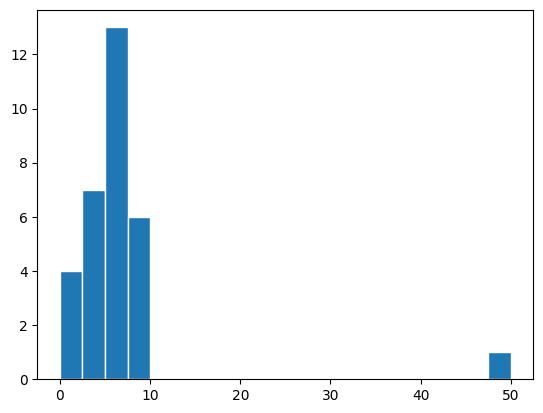

In [6]:
ex = np.concatenate([np.random.randint(0,10,size = 30),np.array([50])])
plt.hist(ex,edgecolor = "white",bins = 20);

### T-Interval Analik Çözüm

CI = $\bar{x} \pm t^{\star}_{dof} * SE$

$dof = n-1$

$t^{\star}:$ For 95% $\alpha = 0.05; \hspace{5mm} lower tail: 1-(0.05)/2 = 0.975$

$SE = \frac {\sigma} {\sqrt{n}}$

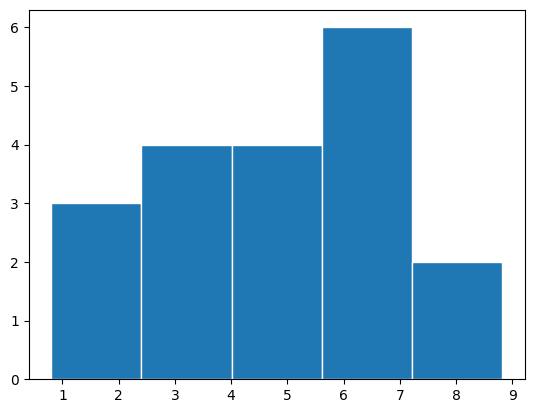

In [7]:
data = np.random.normal(loc = 4.4, scale = 2.3,size = 19)
plt.hist(data,edgecolor = "white",bins = 5);

In [12]:
point_estimate = data.mean()
standard_deviation = data.std()
standard_error = standard_deviation / np.sqrt(len(data))
dof = len(data) - 1
t_val = stats.t.ppf(q = 0.975,df = dof)
interval = (point_estimate - t_val*standard_error, point_estimate + t_val*standard_error)
interval

(3.9589202553604865, 5.932206807675432)

In [13]:
stats.t.interval(confidence = 0.95,
                 df = len(data) - 1,
                 loc = point_estimate,
                 scale = standard_error)

(3.9589202553604865, 5.932206807675432)

### T-Interval Monte Carlo Çözümü

Veri dağılımı hakkında bir varsayım yapmak istemediğimizde kullanılır.

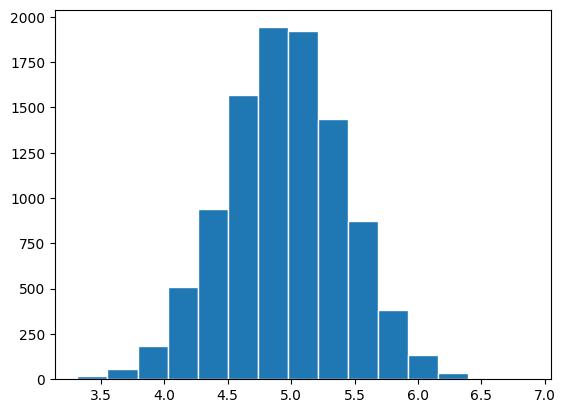

In [10]:
simulation_result = stats.bootstrap((data,),np.mean,confidence_level = 0.95,method = "BCa")
plt.hist(simulation_result.bootstrap_distribution, edgecolor = "white",bins = 15);

In [11]:
simulation_result.confidence_interval

ConfidenceInterval(low=3.9855719356012442, high=5.820145625423637)

## Eşli Verilerin Karşılaştırılması

In [15]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/ucla_textbooks_f18.csv")[["bookstore_new","amazon_new"]]
df.head()

,bookstore_new,amazon_new
0,47.97,47.45
1,14.26,13.55
2,NaN,NaN
3,13.50,12.53
4,49.26,54.95


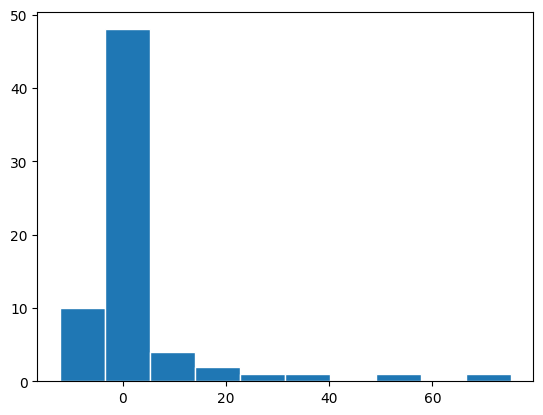

In [23]:
df = df.dropna()
diff = (df["bookstore_new"] - df["amazon_new"]).values
plt.hist(diff,edgecolor = "white",bins = 10);

Ekstrem veriler var. O halde simülasyon

In [24]:
simulation_result = stats.bootstrap((diff,),np.mean,confidence_level = 0.95,method = "BCa")
simulation_result.confidence_interval

ConfidenceInterval(low=1.2009923818190666, high=8.005245500901447)

## İki Ortalama Üzerinden Çıkarımlar



### Analitik Çözüm

$dof = n-1$

$SE = \sqrt{\frac{\sigma_1^2}{n1} + \frac{\sigma_2^2}{n2}}$

$CI = (\bar{x}_{diff} \pm t^{\star}_{dof} \times SE)$

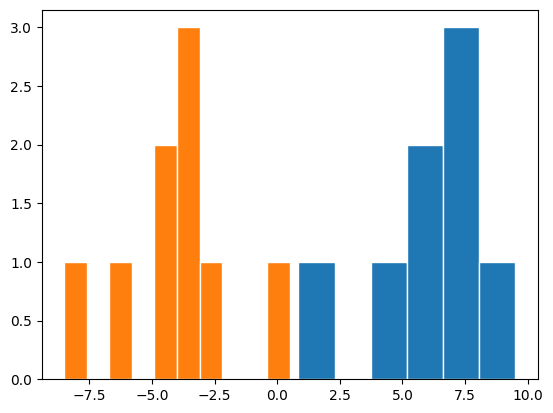

In [25]:
group1 = np.random.normal(loc = 3.5, size = 9, scale = 5.17)
group2 = np.random.normal(loc = -4.33, size = 9, scale = 2.76)

plt.hist(group1,edgecolor = "white",bins = 10);
plt.hist(group2,edgecolor = "white",bins = 10);

In [30]:
np.var(group1,ddof = 1)

19.267239187059193

In [33]:
diff = group1 - group2
standard_error = np.sqrt(group1.var()/len(group1) + group2.var()/len(group2))
point_estimate = diff.mean()

t_val = stats.t.ppf(q = 0.975,df = len(diff) - 1)
interval = (point_estimate - t_val*standard_error, point_estimate + t_val*standard_error)
interval

(5.297691778691247, 12.628699912924729)

### Monte Carlo Çözümü

In [35]:
simulation_result = stats.bootstrap((diff,),np.mean)
simulation_result.confidence_interval

ConfidenceInterval(low=4.782423832520848, high=10.564228684844002)

İki grup kesin farklıdır.

### Permütasyon Testi Çözümü

Veri noktam çok az olduğu için en güvenilir yöntem

In [36]:
n_simulations = 10000
combined_groups = np.concatenate((group1,group2))
p_values = 0
diff_distribution = []

for i in range(n_simulations):
  np.random.shuffle(combined_groups)
  group1_shuffled = combined_groups[:len(group1)]
  group2_shuffled = combined_groups[len(group1):]
  diff = group1_shuffled.mean() - group2_shuffled.mean()
  if diff > point_estimate:
    p_values += 1

  diff_distribution.append(diff)

p_values = p_values / n_simulations
diff_distribution = np.array(diff_distribution)
p_values


0.0002

# Çoklu Ortalama Karşılaştırılması (ANOVA)

**Varsayımlar:**

* Normal
* Bağımsız
* Eşit varyans

In [39]:
group1 = np.random.normal(loc = 0.320,scale = 0.043, size = 160)
group2 = np.random.normal(loc = 0.318,scale = 0.038, size = 205)
group3 = np.random.normal(loc = 0.302,scale = 0.038, size = 64)

stats.bartlett(group1,group2,group3)

BartlettResult(statistic=0.6057191961740057, pvalue=0.7387028043767818)

In [40]:
stats.f_oneway(group1,group2,group3)

F_onewayResult(statistic=8.801914125466567, pvalue=0.0001795762166377791)

In [42]:
print(stats.tukey_hsd(group1,group2,group3))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.004     0.618    -0.014     0.006
 (0 - 2)      0.020     0.002     0.006     0.034
 (1 - 0)      0.004     0.618    -0.006     0.014
 (1 - 2)      0.024     0.000     0.010     0.037
 (2 - 0)     -0.020     0.002    -0.034    -0.006
 (2 - 1)     -0.024     0.000    -0.037    -0.010



# Linear Regression

In [54]:
from sklearn.datasets import load_diabetes

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [47]:
X,y, = load_diabetes(as_frame = True)

In [49]:
X = pd.DataFrame(data.data)
y = pd.DataFrame(data.target)

In [50]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


## Feature Selection

In [56]:
vif_result = [vif(X.values,i) for i in range(X.shape[1])]
col_names = X.columns[1:]
vid_frame = pd.DataFrame(data = zip(col_names,vif_result),columns = ["Features","VIF"])
vid_frame

,Features,VIF
0,sex,1.217307
1,bmi,1.278071
2,bp,1.509437
3,s1,1.459428
4,s2,59.202510
5,s3,39.193370
6,s4,15.402156
7,s5,8.890986
8,s6,10.075967


<Axes: >

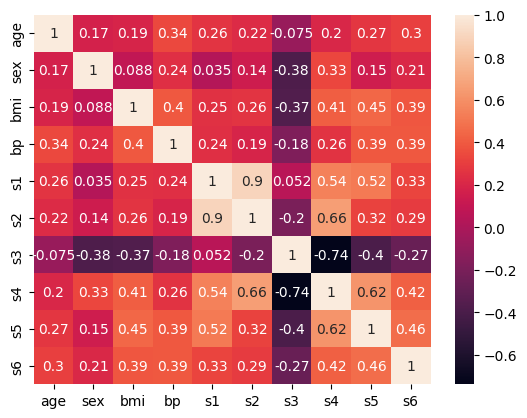

In [57]:
sns.heatmap(X.corr(),annot = True)

s3 ve s4 birbirleri ile çok ilişkin. Elimine edelim.

In [62]:
X_reduced = X.drop(columns = ["s3","s2","s4"])

<Axes: >

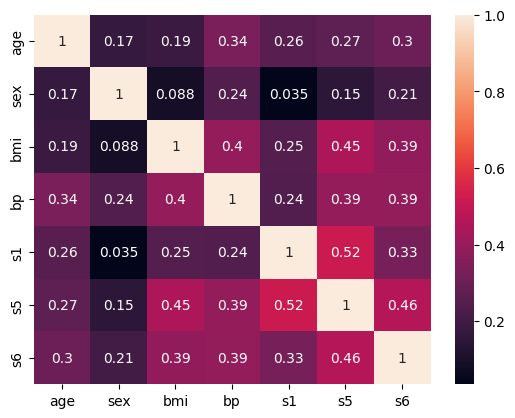

In [63]:
sns.heatmap(X_reduced.corr(),annot = True)

In [ ]:
pg.partial_corr(data = X,x = "age",y = "bmi")

In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

X = sm.add_constant(X)
X_reduced = sm.add_constant(X_reduced)

kf = KFold(n_splits = 4)

full_model_results = []
reduced_model_results = []

for _ in range(5):

  for train_index, test_index in kf.split(X_reduced):
    X_train, X_test = X_reduced.iloc[train_index], X_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    reduced_model_results.append(mean_squared_error(model.predict(X_test),y_test))
    reduced_model_r2.append(model.rsquared)

  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    full_model_results.append(mean_squared_error(model.predict(X_test),y_test))
    full_model_r2.append(model.rsquared)

In [85]:
stats.ttest_ind(full_model_results,reduced_model_results)

TtestResult(statistic=-1.8844191384588704, pvalue=0.06717478269363467, df=38.0)

In [86]:
simulation_results = stats.permutation_test((full_model_results,reduced_model_results),
                       statistic = lambda x,y: np.mean(x) - np.mean(y),
                       n_resamples = 10000)
simulation_results.pvalue

0.06619338066193381

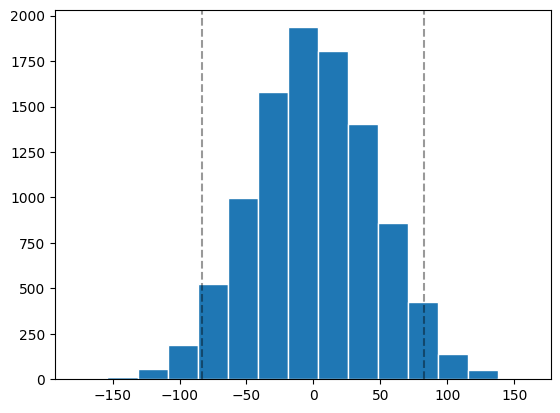

In [87]:
observed_difference = np.mean(full_model_results) - np.mean(reduced_model_results)
plt.figure()
plt.hist(simulation_results.null_distribution,edgecolor = "white",bins = 15);
plt.axvline(x = observed_difference,color = "black",alpha = 0.4, linestyle = "--");
plt.axvline(x = -observed_difference,color = "black",alpha = 0.4, linestyle = "--");
plt.show()

0.00039996000399960006